# Installing the necessary libraries

In [6]:
!pip install numpy
!pip install torch
!pip install sklearn
!pip install pytorch_transformers
!pip install transformers

Could not fetch URL https://pypi.org/simple/numpy/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/numpy/ (Caused by SSLError(PermissionError(1, 'Operation not permitted'))) - skipping
ERROR: Could not find a version that satisfies the requirement numpy (from versions: none)
ERROR: No matching distribution found for numpy
Could not fetch URL https://pypi.org/simple/torch/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/torch/ (Caused by SSLError(PermissionError(1, 'Operation not permitted'))) - skipping
ERROR: Could not find a version that satisfies the requirement torch (from versions: none)
ERROR: No matching distribution found for torch
Could not fetch URL https://pypi.org/simple/sklearn/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries ex

# BERT

In [1]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("/Users/lfoppiano/development/projects/embeddings/pre-trained-embeddings/bert/bert-base-cased-hf")
model = AutoModel.from_pretrained("/Users/lfoppiano/development/projects/embeddings/pre-trained-embeddings/bert/bert-base-cased-hf",output_hidden_states=True)

Some weights of the model checkpoint at /Users/lfoppiano/development/projects/embeddings/pre-trained-embeddings/bert/bert-base-cased-hf were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Vector calculation

Borrowed at https://github.com/stockmarkteam/bert-book/blob/master/Chapter10.ipynb
thanks to Oka-san

This method averages the last hidden state values, using the attention mask for coefficients


In [2]:
import numpy as np
import torch
import glob

max_length = 256
sentence_vectors = []
classifications = []
for file in glob.glob(f'./resources/supermat_classification.?.tsv'):
    print(file)
    lines = open(file).read().splitlines()
    for line in lines:
        split = line.split("\t")
        if len(split) < 2:
            print("skip ", line)
            continue

        text = split[1]
        classification = split[2]

        encoding = tokenizer(
            text,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        encoding = { k: v for k, v in encoding.items() }
        attention_mask = encoding['attention_mask']

        with torch.no_grad():
            output = model(**encoding)
            last_hidden_state = output.last_hidden_state
            cross_attention = output.cross_attentions
            averaged_hidden_state = (last_hidden_state * attention_mask.unsqueeze(-1)).sum(1) / attention_mask.sum(1, keepdim=True)

        sentence_vectors.append(averaged_hidden_state[0].cpu().numpy())
        classifications.append(classification)


sentence_vectors = np.vstack(sentence_vectors)
labels = np.array(classifications)

./resources/supermat_classification.1.tsv
./resources/supermat_classification.0.tsv


## Dimension reduction


In [3]:
from sklearn.decomposition import PCA

sentence_vectors_pca = PCA(n_components=2).fit_transform(sentence_vectors)

# plot

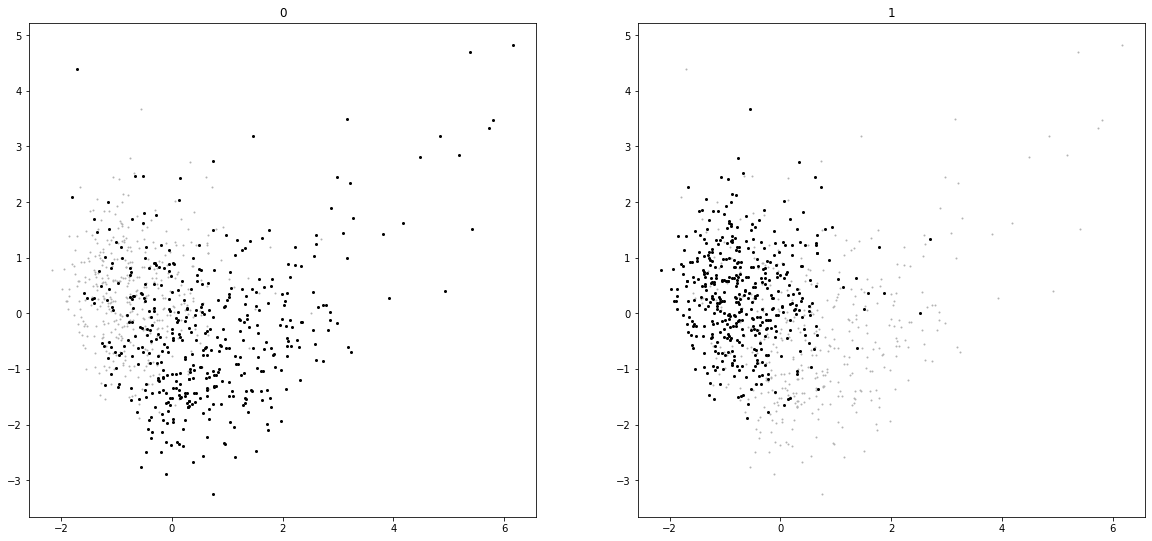

In [10]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20,20))
for label in range(2):
    plt.subplot(2,2,label+1)
    # index = [True if l == label else False for l in labels]
    index = str(label) == labels
    plt.plot(
        sentence_vectors_pca[:,0],
        sentence_vectors_pca[:,1],
        'o',
        markersize=1,
        color=[0.7, 0.7, 0.7]
    )
    plt.plot(
        sentence_vectors_pca[index,0],
        sentence_vectors_pca[index,1],
        'o',
        markersize=2,
        color='k'
    )
    plt.title(label)

In [11]:
from sklearn.manifold import TSNE

sentence_vectors_tsne = TSNE(n_components=2).fit_transform(sentence_vectors)

/Users/lfoppiano/opt/anaconda3/envs/bert_tutorial/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/lfoppiano/opt/anaconda3/envs/bert_tutorial/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


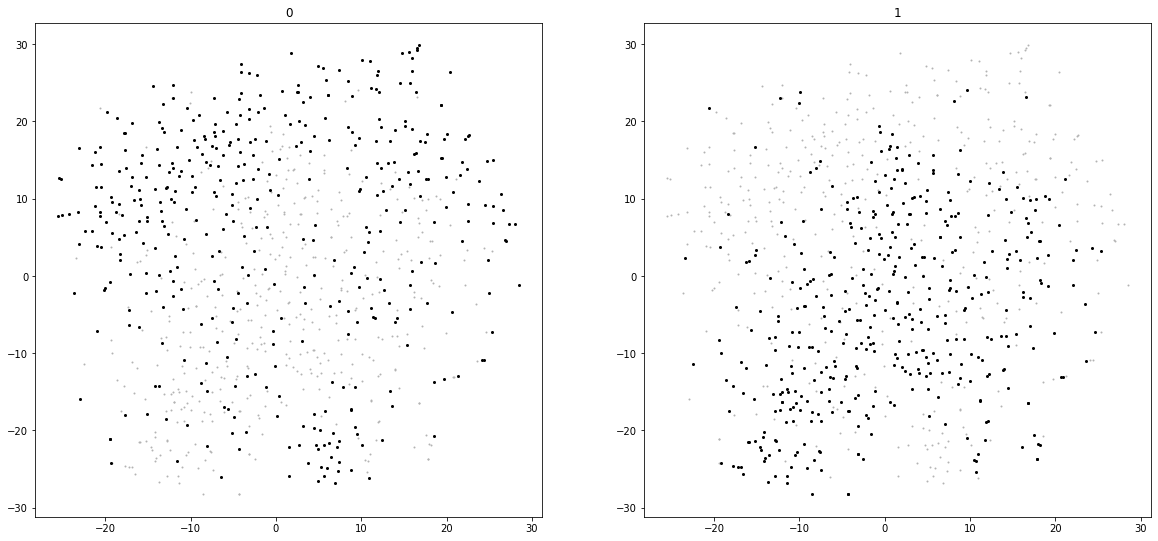

In [13]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20,20))
for label in range(2):
    plt.subplot(2,2,label+1)
    # index = [True if l == label else False for l in labels]
    index = str(label) == labels
    plt.plot(
        sentence_vectors_tsne[:,0],
        sentence_vectors_tsne[:,1],
        'o',
        markersize=1,
        color=[0.7, 0.7, 0.7]
    )
    plt.plot(
        sentence_vectors_tsne[index,0],
        sentence_vectors_tsne[index,1],
        'o',
        markersize=2,
        color='k'
    )
    plt.title(label)